# Лабораторная работа №4
## Кривошейкин Сергей Р3214

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('4_f_1.csv', names = ['R'])
R = data.R
R

0      866
1      927
2      924
3      892
4      897
      ... 
295    842
296    829
297    806
298    883
299    882
Name: R, Length: 300, dtype: int64

##### 1. По заданному массиву кардиоинтервалов построить кардиоритмограмму,представляющую собой зависимость длительности кардиоинтервалов от времени.

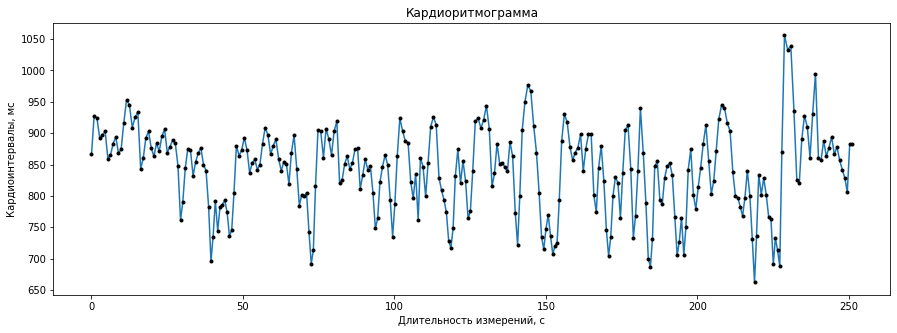

In [3]:
signal = np.array(R)
time_x = [0]
for i in range(0,len(signal)-1):
    time_x.append(signal[i]/1000+time_x[i])
plt.figure(figsize=(15, 5))
plt.plot(time_x, signal)
plt.plot(time_x, signal, '.', color='black')
plt.title('Кардиоритмограмма')
plt.ylabel('Кардиоинтервалы, мс')
plt.xlabel('Длительность измерений, с')
plt.show()

##### Кубическая интерполяция

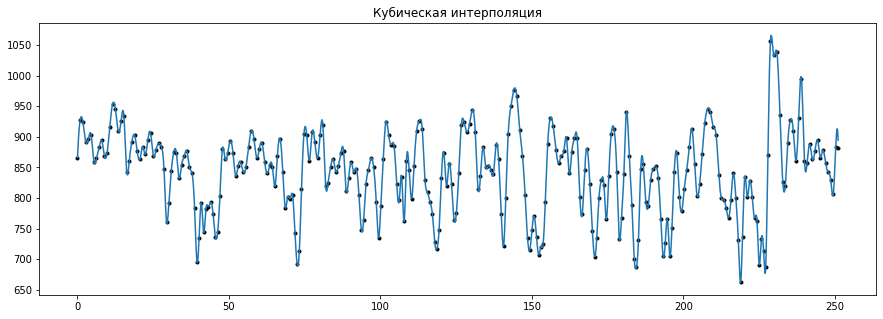

In [4]:
from scipy.interpolate import CubicSpline
cs = CubicSpline(time_x, signal)
xs = np.arange(0, max(time_x), 0.1)
plt.figure(figsize=(15, 5))
plt.title('Кубическая интерполяция')
plt.plot(time_x, signal, '.', color='black')
plt.plot(xs, cs(xs))
plt.show()

##### 2. Преобразование Фурье

Для преобразования Фурье пользуюсь куском кода, который Дмитрий Геннадьевич предоставил в ходе конференции в Zoom
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python

In [5]:
import scipy.fftpack
def polarToRectangular(radii, angles):
    return radii * np.exp(1j * angles)

def sortZip(x, y):
    order = np.argsort(x)
    xs = np.array(x)[order]
    ys = np.array(y)[order]
    return xs, ys

def plotSort(x, y):
    xs, ys = sortZip(x, y)
    plt.plot(xs, ys)
    
def frequencyGenerator(time, steps=None):
    𝛿 = time.max() - time.min()
    if steps is None:
        steps = int(𝛿 / np.diff(time).mean() / 2)
    M = np.arange(1, steps + 1)
    return M / 𝛿, steps

def easyFourierTransform(time, signal, frequency=None, steps=None, sorted=False, uniform=False):
    if sorted:
        ts = time
        Xs = signal
    else:
        ts, Xs = sortZip(time, signal)
    
    if frequency is None:
        frequency, steps = frequencyGenerator(ts, steps)
    else:
        steps = frequency.shape[0]
    
    if uniform:
        N = signal.shape[0]
        amplitude = np.abs(scipy.fftpack.fft(signal)[:steps]) * 2.0 / N
    else:
        ft = frequency[:, np.newaxis]
        𝜃 = (ts - ts.min()) * 2 * np.pi * ft
        Y = polarToRectangular(Xs, 𝜃)[:, 1:] * np.diff(ts)
        amplitude = np.abs(Y.sum(axis=1))
    return frequency, amplitude

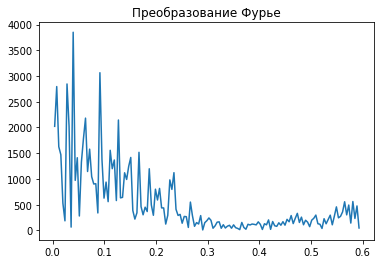

In [6]:
freq, sample_fourier = easyFourierTransform(time_x, signal)
plt.plot(freq, sample_fourier)
plt.title("Преобразование Фурье")
n_batch=len(freq)

##### 3. Рассчитать спектральную мощность полученного сигнала и построить график зависимости спектральной плотности мощности временной последовательности длительностей кардиоинтервалов от частоты.

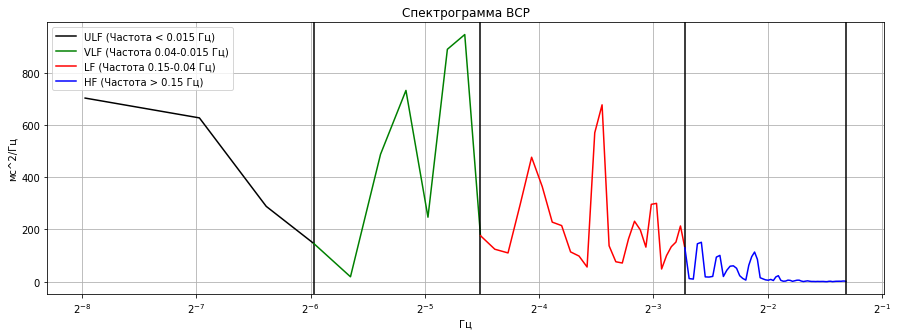

In [7]:
sample_fourier *= math.sqrt(2)

borders_freq = [0, 0.015, 0.04, 0.15, 0.4, float('+inf')]

final_values = np.array(abs(np.power(sample_fourier, 2)/(n_batch**2)))
final_values = [val.real for val in final_values]
final_values = final_values[0*n_batch:1*n_batch]
final_values[0] = final_values[1]

final_values[1:n_batch-1] = np.add(final_values[1:n_batch-1],final_values[1:n_batch-1])
final_values[1:n_batch-1] = np.add(final_values[1:n_batch-1],final_values[2:n_batch])
final_values[1:n_batch-1]/=np.ones(len(final_values)-2)*3

part = 0
final_vals = [[]]
final_freq = [[]]
for h, v in zip(freq, final_values):
    if h > borders_freq[part+1]:
        final_freq[part].append(h)
        final_vals[part].append(v)
        part+=1
        final_freq.append([])
        final_vals.append([])
    final_freq[part].append(h)
    final_vals[part].append(v)

plt.figure(figsize=(15, 5))
colors = ['black','green','red','blue']
labels = ['ULF (Частота < 0.015 Гц)', 'VLF (Частота 0.04-0.015 Гц)', 'LF (Частота 0.15-0.04 Гц)', 'HF (Частота > 0.15 Гц)']

for val, h, col, lab in zip(final_vals, final_freq, colors, labels):
    plt.plot(h, val, color = col, label = lab)
    plt.axvline(x=h[-1], color = 'black')
plt.grid()
x_label = plt.xlabel('Гц')
y_label = plt.ylabel('мс^2/Гц')
title = plt.title('Спектрограмма ВСР')
plt.xscale(value='log', basex=2)
plt.legend(ncol=1)
plt.show()

##### 4,5. Рассчитать мощности спектров в каждом из указанных диапазоне частот, указать их минимальное и максимальное значения, суммарную мощность спектра ВСР и мощности спектра в каждом частотном диапазоне в процентном отношении ко всему диапазону.

In [8]:
f_max = []
f_min = []
power = []
for l in final_vals:
    f_max.append(max(l))
    f_min.append(min(l))
    power.append(sum(l))
total = sum(power)
print(f'Суммарная мощность спектра ВСР = {total}')
for mx, mn, pw, lab in zip(f_max, f_min, power, labels):
    print(f'В диапазоне {lab}:\n\t Максимальное значение плотности мощности = {mx}'+
            f'\n\t Минимальное значение плотности мощности = {mn}'+
            f'\n\t Мощность = {pw}, что составляет {pw/total*100}% общей мощности')

Суммарная мощность спектра ВСР = 13149.60471668401
В диапазоне ULF (Частота < 0.015 Гц):
	 Максимальное значение плотности мощности = 703.5264566402382
	 Минимальное значение плотности мощности = 146.57681246304608
	 Мощность = 1766.2049225528674, что составляет 13.43161988977459% общей мощности
В диапазоне VLF (Частота 0.04-0.015 Гц):
	 Максимальное значение плотности мощности = 946.9462279450078
	 Минимальное значение плотности мощности = 18.73926284598397
	 Мощность = 3647.1859487376987, что составляет 27.736088097843787% общей мощности
В диапазоне LF (Частота 0.15-0.04 Гц):
	 Максимальное значение плотности мощности = 677.6582016855538
	 Минимальное значение плотности мощности = 48.59369531984576
	 Мощность = 5893.37688544438, что составляет 44.81790146868032% общей мощности
В диапазоне HF (Частота > 0.15 Гц):
	 Максимальное значение плотности мощности = 150.96665171240417
	 Минимальное значение плотности мощности = 0.09413576489112975
	 Мощность = 1491.9593108888735, что составляе

##### 6. Рассчитать индекс централизации ИЦ (IC), индекс вагосимпатического взаимодействия ИВВ и индекс активации подкорковых нервных центров ИАП (ISCA).

In [9]:
n_to_i = {'HF':0, 'LF':1, 'VLF':2, 'ULF':3}
IC = (power[n_to_i['VLF']] + power[n_to_i['LF']])/power[n_to_i['HF']]
IVV = (power[n_to_i['LF']])/power[n_to_i['HF']]
ISCA = (power[n_to_i['LF']])/power[n_to_i['VLF']]
print('Индексы:')
print(f'\tИндекс централизации ИЦ (IC): {IC}\n'+
      f'\tИндекс вагосимпатического взаимодействия ИВВ: {IVV}\n'+
      f'\tИндекс активации подкорковых нервных центров ИАП (ISCA): {ISCA}')

Индексы:
	Индекс централизации ИЦ (IC): 5.401730406453729
	Индекс вагосимпатического взаимодействия ИВВ: 2.0649845905004427
	Индекс активации подкорковых нервных центров ИАП (ISCA): 0.6188618205880598


##### 7. Анализ полученных данных

Показатель HF - отвечает за относительный уровень активности парасимпатического звена регуляции. Мощность невелика - 11.3% общей мощности. Значение плотности мощности лежат в интервале [0.009; 150.9] $msec^2/Hz$ .

Показатель LF - отвечает за относительный уровень активности вазомоторного центра. Почти половина общей мощности - 44.8%. Значение плотности мощности лежат в интервале [48.6; 677.7] $msec^2/Hz$

Показатель VLF - отвечает за относительный уровень активности симпатического звена регуляции. Мощность уступает лишь LF - 27.7% от общей. Значение плотности мощности лежат в интервале [18.7; 947] $msec^2/Hz$

Показатель ULF - отвечает за относительный уровень активности субкортикальных уровней регуляции (высших вегетативных центров). Мощность - 13.4% общей мощности, как и HF - невелика относительно других. Значение плотности мощности лежат в интервале [146.6; 703.5] $msec^2/Hz$

Индекс централизации отражает степень централизации управления ритмом сердца (преобладания активности центрального контура регуляции над автономным, т.е. преобладание недыхательных составляющих синусовой аритмии над дыхательными). В нашем случае он равен $5.4$.

Индекс активации подкорковых нервных центров ИАП характеризует активность сердечно-сосудистого подкоркового нервного центра по отношению к более высоким уровням управления. Увеличение ИАП свидетельствует о повышенной активности подкорковых нервных центров. В нашем случае он равен $0.6$.